In [1]:
# caricamento dei file importati
from IPython.display import display

safe_cols = ['data_ora', 'durata', 'tipo', 'da_torre_cell_inizio', 'da_torre_cell_fine', 'da_cgi_inizio', 'da_cgi_fine', 'a_torre_cell_inizio', 'a_torre_cell_fine', 'a_cgi_inizio', 'a_cgi_fine', 'operatore', 'nome_file_importato', 'esito_chiamata'] # set di colonne non contenti dati personali

import pandas as pd
import numpy as np
from os import listdir

# i dati vengono concatenati in un unico dataframe per comodità
dfs = []
for file in listdir('extracted_data'):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv('extracted_data/{}'.format(file), dtype=str, sep=';')
    dfs.append(df)
df = pd.concat(dfs)

df[safe_cols]

,data_ora,durata,tipo,da_torre_cell_inizio,da_torre_cell_fine,da_cgi_inizio,da_cgi_fine,a_torre_cell_inizio,a_torre_cell_fine,a_cgi_inizio,a_cgi_fine,operatore,nome_file_importato,esito_chiamata
0,25-03-2018 00:32:18,17,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
1,13-04-2018 20:27:22,4,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
2,18-04-2018 09:18:39,45,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
3,19-04-2018 20:16:21,17,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
4,30-04-2018 06:03:30,10,V,NaN,NaN,VAVI33I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11228,28/12/2017 16:43:27,9,V,NaN,NaN,NaN,NaN,561014-PIAZZA STAZIONE 10 - 50100 - FIRENZE (F...,561014-PIAZZA STAZIONE 10 - 50100 - FIRENZE (F...,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11229,28/11/2017 14:19:07,0,S,"014360065-STADIO COMUNALE S. GIUSTO, VIALE BAG...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11230,04/12/2017 17:44:23,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11231,04/12/2017 17:44:23,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0


> !! sono stati nascosti i dati personali !!

In [2]:
# carico le librerie necesarrie alla connessione con JanusGrpah

# workaround per un bug nella libreria async quando si lavora con i notebook notebook
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

from gremlin_python import statics
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.traversal import T
from gremlin_python.process.traversal import Order
from gremlin_python.process.traversal import Cardinality
from gremlin_python.process.traversal import Column
from gremlin_python.process.traversal import Direction
from gremlin_python.process.traversal import Operator
from gremlin_python.process.traversal import P
from gremlin_python.process.traversal import Pop
from gremlin_python.process.traversal import Scope
from gremlin_python.process.traversal import Barrier
from gremlin_python.process.traversal import Bindings
from gremlin_python.process.traversal import WithOptions

g = traversal().withRemote(DriverRemoteConnection('ws://jce-janusgraph:8182/gremlin', 'tabulati_traversal'))

You should consider upgrading via the '/home/vscode/.pyenv/versions/3.8.6/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
# molti numeri possono essere stati filtrati dal software perchè non validi e devono essere filtrati

import phonenumbers

# uso la funzione di filtraggio usata dal programma di mappatura
def _map_phone(phone: str) -> str:
    try:
        n = phonenumbers.parse(
            phone, None if phone.startswith('+') else 'IT')
        if not phonenumbers.is_possible_number(n):
            return ''
        return phonenumbers.format_number(n, phonenumbers.PhoneNumberFormat.E164)
    except:
        return ''

df['da_numero'] = df['da_numero'].apply(_map_phone)
df = df[df['da_numero'] != '']

df['a_numero'] = df['a_numero'].apply(_map_phone)
df = df[df['a_numero'] != '']

# trasformo le date in oggetti datetime
import dateparser

ddp = dateparser.DateDataParser(languages=['it'], settings={
    'DATE_ORDER': 'DMY'
})

def parse_date(s: str):
    data = ddp.get_date_data(s)
    if data:
        return data['date_obj']
    raise Exception('invalid date')
df['data_ora'] = df['data_ora'].apply(parse_date)

df[safe_cols]

,data_ora,durata,tipo,da_torre_cell_inizio,da_torre_cell_fine,da_cgi_inizio,da_cgi_fine,a_torre_cell_inizio,a_torre_cell_fine,a_cgi_inizio,a_cgi_fine,operatore,nome_file_importato,esito_chiamata
0,2018-03-25 00:32:18,17,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
1,2018-04-13 20:27:22,4,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
2,2018-04-18 09:18:39,45,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
3,2018-04-19 20:16:21,17,V,NaN,NaN,SZMI11I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
4,2018-04-30 06:03:30,10,V,NaN,NaN,VAVI33I,NaN,NaN,NaN,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11228,2017-12-28 16:43:27,9,V,NaN,NaN,NaN,NaN,561014-PIAZZA STAZIONE 10 - 50100 - FIRENZE (F...,561014-PIAZZA STAZIONE 10 - 50100 - FIRENZE (F...,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11229,2017-11-28 14:19:07,0,S,"014360065-STADIO COMUNALE S. GIUSTO, VIALE BAG...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11230,2017-12-04 17:44:23,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11231,2017-12-04 17:44:23,0,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0


In [4]:
# il primo controllo da fare è che il numero di numeri di telefono unici deve corrispondere al numero di nodi inseriti

# concateno le colonne contenti i numeri di telefono e rimuovo i duplicati
numeri = pd.concat([df['da_numero'], df['a_numero']])
numeri = numeri.drop_duplicates()


In [5]:
# controllo che i nodi inseriti abbiano lo stesso numero dei numeri unici trovati
g.V().count().next()

52081

In [6]:
# verifico non ci siano nodi duplicati

g.V().groupCount().by('numero').unfold().where(__.select(Column.values).is_(P.gt(1))).count().next()

0

Il risultato mostra che non sono presenti nodi con numero duplicato

In [7]:
# per scrupolo verifico che i nodi senza duplicati equivalgano al numero totale di nodi

g.V().groupCount().by('numero').unfold().where(__.select(Column.values).is_(P.eq(1))).count().next()

52081

In [8]:
# il secondo controllo è verificare il numero di archi inseriti, che devono essere uguali al numero di chiamate uniche
# le chiamate sono considerate non duplicate se almeno uno tra da_numero, a_numero, data_ora, durata

dfc = df.drop_duplicates(subset=['da_numero', 'a_numero', 'data_ora', 'durata'], inplace=False)
dfc

,data_ora,durata,tipo,da_torre_cell_inizio,da_torre_cell_fine,da_cgi_inizio,da_cgi_fine,da_numero,da_imei,da_imsi,a_torre_cell_inizio,a_torre_cell_fine,a_cgi_inizio,a_cgi_fine,a_numero,a_imei,a_imsi,operatore,nome_file_importato,esito_chiamata
0,2018-03-25 00:32:18,17,V,NaN,NaN,SZMI11I,NaN,+393533630818,NaN,NaN,NaN,NaN,NaN,NaN,+393248693409,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
1,2018-04-13 20:27:22,4,V,NaN,NaN,SZMI11I,NaN,+393533630818,NaN,NaN,NaN,NaN,NaN,NaN,+393248693409,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
2,2018-04-18 09:18:39,45,V,NaN,NaN,SZMI11I,NaN,+393533630818,NaN,NaN,NaN,NaN,NaN,NaN,+393801252456,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
3,2018-04-19 20:16:21,17,V,NaN,NaN,SZMI11I,NaN,+393533630818,NaN,NaN,NaN,NaN,NaN,NaN,+393208913049,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
4,2018-04-30 06:03:30,10,V,NaN,NaN,VAVI33I,NaN,+393533630818,NaN,NaN,NaN,NaN,NaN,NaN,+393801252456,NaN,NaN,BT Italia,data/f8_01/f8_01/BT Italia/SD320406560.csv,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,2017-12-19 15:31:27,7,V,NaN,NaN,NaN,NaN,+393317996289,NaN,NaN,531806-CIMITERO DI SOFFIANO - 50100 - FIRENZE ...,560425-CENTRALE TELECOM C/O VIA DEL POLLAIOLO ...,NaN,NaN,+393913462716,865549031323560,222992312745857,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11225,2017-12-28 13:16:54,1,V,531806-CIMITERO DI SOFFIANO - 50100 - FIRENZE ...,531806-CIMITERO DI SOFFIANO - 50100 - FIRENZE ...,NaN,NaN,+393913462716,865549031323560,222992312745857,NaN,NaN,NaN,NaN,+393317996289,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11227,2017-12-28 16:43:27,9,X,NaN,NaN,NaN,NaN,+393317996289,NaN,222992312745857,NaN,NaN,NaN,NaN,+393286539148,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0
11229,2017-11-28 14:19:07,0,S,"014360065-STADIO COMUNALE S. GIUSTO, VIALE BAG...",NaN,NaN,NaN,+393286539148,359303063454770,222992401453818,NaN,NaN,NaN,NaN,+393317996289,NaN,NaN,WindTre,data/14Tab/Files Orig/Files Orig/Wind/LRMS_LAW...,0


In [9]:
# controllo che gli archi inseriti abbiano lo stesso numero delle chiamate uniche trovate
edges_count = g.E().count().next()

edges_count

327596

In [10]:
# Verifico non ci siano archi duplicati
# Come nel caso dei nodi faccio ricorso a groupCount()
# Dato che le informazioni relative al numero di telefono sono contenute nei nodi devo prima visitare i nodi
# su cui l'arco è incidente

g.E().as_('e') \
    .outV().properties('numero').as_('da_numero') \
    .select('e').inV().properties('numero').as_('a_numero') \
    .select('e').properties('dataOra').as_('dataOra') \
    .select('e').properties('durata').as_('durata') \
    .select('da_numero', 'a_numero', 'dataOra', 'durata') \
    .groupCount().by(__.select('da_numero', 'a_numero', 'dataOra', 'durata')) \
    .unfold().where(__.select(Column.values).is_(P.gt(1))).count().next()

0

In [11]:
# verifico che gli archi senza duplicati equivalgano al numero di chiamate

g.E().as_('e') \
    .outV().properties('numero').as_('da_numero') \
    .select('e').inV().properties('numero').as_('a_numero') \
    .select('e').properties('dataOra').as_('dataOra') \
    .select('e').properties('durata').as_('durata') \
    .select('da_numero', 'a_numero', 'dataOra', 'durata') \
    .groupCount().by(__.select('da_numero', 'a_numero', 'dataOra', 'durata')) \
    .unfold().where(__.select(Column.values).is_(P.eq(1))).count().next()

327596

# Analisi
### !! NOTA !!
Dato che è stato dimostrato che i numeri di telefono sono unici e dato che lo sono anche gli id dei nodi, d'ora in avanti saranno utilizzati al posto dei numeri di telefono, nel rispetto della privacy delle persone coinvolte nell'indagine. 

## Centralità
Uno dei concetti più importanti in un grafo è sicuramente quello della centralità.
Permette di misurare l'importanza dei nodi all'interno del grafo.
Ci sono vari tipi di centralità, ed ognuno prende in esame un diverso aspetto.

### Grado
Per grafi non orientati il grado di un nodo è definito dal numero di grafi incidenti in esso.  
Nonostante il grafo sia orientato è sicuramente utile per individuare i nodi con il traffico più significativo.

In [12]:
# configurazione libreria per i grafici
# colgo l'occasione per ringraziare il professor Malchiodi la parte di laboratorio di statistica è stata molto utile per la parte di analisi

import matplotlib.pyplot as plt
from scipy.constants import golden
from scipy import stats

plt.style.use('fivethirtyeight')
size = 10.0
plt.rc('figure', figsize=(size, size/golden))

In [13]:
dc = g.V().group().by().by(__.bothE().count()).next()

d = []
for v in dc.keys():
    d.append({
        'id': v.id,
        'dc': dc[v]
    })
dfdc = pd.json_normalize(d).set_index('id')
dfdc

,dc
id,
15728880,15
5767256,3
6291552,2
6815848,3
11010216,1
...,...
43380832,5
43511904,2
43642976,2


In [14]:
degree_centrality = dfdc['dc'].value_counts().sort_index()
degree_centrality

1         18739
2         14522
3          4680
4          4359
5          1938
          ...  
19696         1
20854         1
21377         1
31119         1
133613        1
Name: dc, Length: 362, dtype: int64

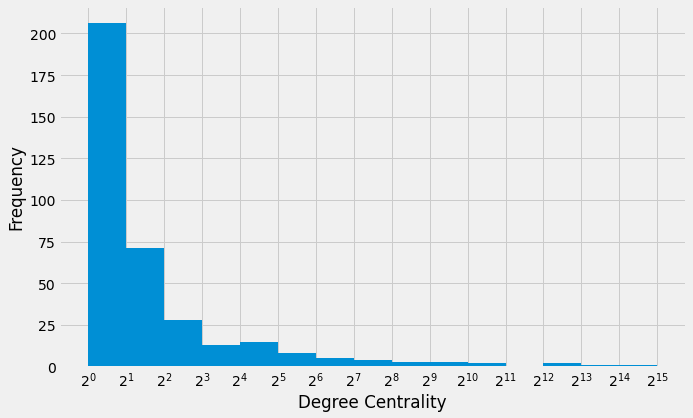

In [15]:
bins = [2**i for i in range(0, 16)]
ax = degree_centrality.plot.hist(bins=bins)
ax.set_xlabel('Degree Centrality')
ax.set_xscale('log', base=2)
ax.set_xticks(bins)

plt.show()

Dal grafico si evince che la maggior parte dei nodi ha un basso grado, che si traduce in un basso livello di traffico.  
La quantità di nodi con grado elevato è decisamente inferiore.  
Già da questo grafico si può determinare che i nodi più "interessanti" sono in quantità ridotta.


In [16]:
# isolo i nodi con grado maggiore

min_degree = 1024 # 2^10

high_degree_centrality = dfdc[dfdc['dc'] >= min_degree]
high_degree_centrality


,dc
id,
12976232,6604
26607712,2569
13635824,1168
13373608,2688
921840,1466
27795552,1638
13643864,3640
1323232,1474
1851488,2475


I nodi con grado maggiore a min_degree sono in numero estremamente ridotto

In [17]:
percentile = stats.percentileofscore(dfdc['dc'], min_degree)

100-percentile

0.11136498915151094

Ipotizzando che i nodi di interesse siano quelli ad alto traffico, possiamo già ecludere più del 99% dei nodi.  
I nodi più significativi sono difatti circa lo 0.11% del totale.  
Questa prima analisi ci permette già di escludere la maggior parte dei nodi, focalizzandoci sui rimanenti.

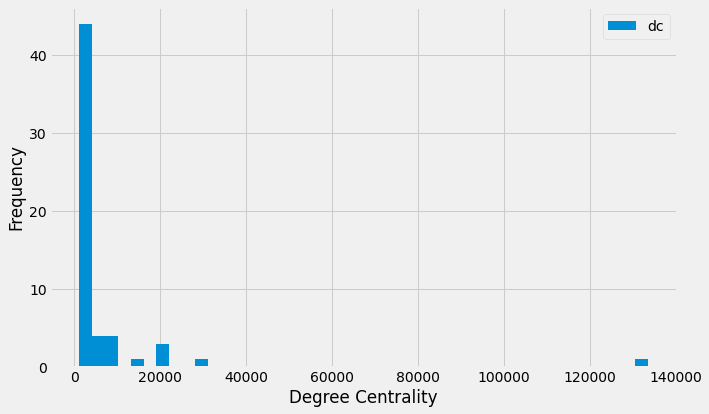

In [18]:
ax = high_degree_centrality.plot.hist(bins=44)
ax.set_xlabel('Degree Centrality')
plt.show()

Anche in questo caso osserviamo che i nodi con grado maggiore sono molto pochi rispetto a quelli con grado minore.

In [19]:
# Vediamo il valore massimo del grado e quanto pesa sul totale
max_degree = max(dfdc['dc'])

(max_degree, max_degree / edges_count * 100)

(133613, 40.78590703183189)

Un nodo unico genera più del 40% del traffico. Sicuramente è un caso interessante.

In [20]:
 dfdc[dfdc['dc'] == max_degree]

,dc
id,
331776,133613


Molto probabilmente 331776 è l'entità su cui è incentrata l'indagine. Sicuramente è un nodo di interesse.

In [21]:
# verifichiamo che effettivamente la maggior parte delle conversazioni siano in entrata o in uscita da questi nodi
high_degree_centrality_ids = [id for id in high_degree_centrality.index]

high_degree_centrality_edge_count = g.V().hasId(high_degree_centrality_ids).bothE().dedup().count().next()
high_degree_centrality_edge_count

311444

In [22]:
high_degree_centrality_edge_count / edges_count

0.9506953686858204

Come ci si può aspettare più del 95% delle conversazioni partono o arrivano in questi nodi.  
Potrebbe essere interessante sapere se questi nodi hanno interazioni tra loro.

In [23]:
high_degree_centrality_edges = g.V(high_degree_centrality_ids) \
    .outE().filter(
        __.inV().hasId(P.within(high_degree_centrality_ids))
    ).project('source', 'target') \
        .by(__.outV().id()) \
        .by(__.inV().id()) \
    .groupCount() \
        .by(__.select('source', 'target').fold()) \
    .unfold().where(
        __.select(Column.values).is_(P.gt(0))
    ) \
    .project('source', 'target', 'count') \
        .by(__.select(Column.keys).unfold().select('source')) \
        .by(__.select(Column.keys).unfold().select('target')) \
        .by(__.select(Column.values))

high_degree_centrality_edges = pd.DataFrame(high_degree_centrality_edges)
high_degree_centrality_edges

,source,target,count
0,1880160,1110256,1
1,876648,26787936,1165
2,13643864,13426688,120
3,327920,1880160,1099
4,13373608,13373608,1
...,...,...,...
146,921840,1880160,2
147,921840,1851488,17
148,888936,921840,4
149,634976,913608,606


In [24]:
high_degree_centrality_connected_nodes = pd.concat([high_degree_centrality_edges['source'], high_degree_centrality_edges['target']]).unique()
pd.Series(high_degree_centrality_connected_nodes)

0      1880160
1       876648
2     13643864
3       327920
4     13373608
5      1851488
6     13426688
7      1405024
8       634976
9       913608
10      921840
11      319688
12    27967584
13      356520
14    27795552
15     1433768
16    12882008
17      987304
18    13733888
19    21197040
20    13168744
21    12976232
22    12963944
23      577736
24    13017288
25     1241328
26    13635824
27    28373088
28    12681272
29      872672
30     1359960
31      344120
32    13099176
33    13533240
34      913648
35    12918872
36    14348488
37    21463208
38     1110256
39    12607688
40     1921024
41     1331368
42      888936
43     2732128
44      880728
45     1372400
46      331776
47     1323232
48    26787936
49    26607712
50     2744416
51     1245424
52    21299256
53      647256
54    26046560
dtype: int64

Dei 58 nodi iniziali solo 3 sono risultati isolati.

Andiamo a generare una visualizzazione del grafo per capire in che modo sono collegati.

In [25]:
 import jugri
 
 q = g.V(high_degree_centrality_ids).outE() \
    .filter(
        __.inV().hasId(P.within(high_degree_centrality_ids))
    ).project('id', 'label', 'source', 'target', 'dataOra', 'durata') \
        .by(__.id()) \
        .by(__.label()) \
        .by(__.outV().id()) \
        .by(__.inV().id()) \
        .by('dataOra') \
        .by('durata')
graph_data = jugri.to_df(q)
del graph_data['id.@type']
graph_data.rename(columns={'id.@value.relationId': 'id'})
graph_data['dataOra'] = graph_data['dataOra'].apply(lambda e: e.utcnow().isoformat())
graph_data

,id.@value.relationId,label,source,target,dataOra,durata
0,g7oy5-7q4iw-4r9-isfc,chiamato,12976232,876648,2021-04-10T23:27:04.355735+00:00,3
1,g7pcd-7q4iw-4r9-isfc,chiamato,12976232,876648,2021-04-10T23:27:04.355791+00:00,4
2,g7qx9-7q4iw-4r9-isfc,chiamato,12976232,876648,2021-04-10T23:27:04.355803+00:00,3077
3,g7rbh-7q4iw-4r9-isfc,chiamato,12976232,876648,2021-04-10T23:27:04.355812+00:00,39
4,g7rpp-7q4iw-4r9-isfc,chiamato,12976232,876648,2021-04-10T23:27:04.355821+00:00,40
...,...,...,...,...,...,...
71691,1bq80u-jkz4-4r9-jky0,chiamato,913648,913608,2021-04-10T23:27:05.093644+00:00,0
71692,1bq8f2-jkz4-4r9-jky0,chiamato,913648,913608,2021-04-10T23:27:05.093652+00:00,0
71693,1bq8ta-jkz4-4r9-jky0,chiamato,913648,913608,2021-04-10T23:27:05.093661+00:00,273
71694,1bq97i-jkz4-4r9-jky0,chiamato,913648,913608,2021-04-10T23:27:05.093670+00:00,274


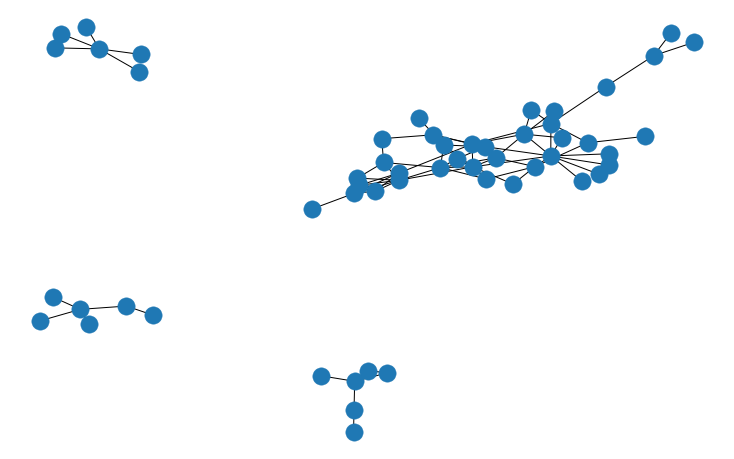

In [26]:
# visualizzazione statica in caso quella dinamica non funzioni

import networkx as nx

G = nx.from_pandas_edgelist(graph_data, edge_attr=['dataOra', 'durata'])
nx.draw(G)
plt.show()

In [27]:
# renderizzo il grafo interattivo
from pyvis.network import Network

nt = Network(width='1024px', height='768px', notebook=True)
nt.from_nx(G)
nt.show('nx.html')

Dal rendering si individuano diverse foreste, una di grandi dimensioni 3 di dimensioni più ridotte.  
Dalla visualizzazione è immediato individuare le probabili reti di conoscenze tra gli individui.